In [5]:
import os
import csv

class CSVWorker:
    def __init__(self, path: str, amount: int = None):
        self.path = path if path[-1] == "/" else f"{path}/"
        self.dialogs = [f"{self.path}{f}" for f in os.listdir(path) if f.endswith(".csv")]

        if amount:
            self.dialogs = self.dialogs[:amount]

In [6]:
def launch_chain(handler):
    csv_worker = CSVWorker("dialogs", 20)

    for dialog in csv_worker.dialogs:
        with open(dialog, mode="r") as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                handler.handle(message=row)

    handler.response()

import matplotlib.pyplot as plt
from itertools import islice


def chunks(data, size):
    it = iter(data)
    data_len = len(data)
    exact = data_len // size
    rest = data_len % size if data_len > size else 0
    slices = [*([exact] * size)]
    slices = slices if not rest else slices + [rest]

    if not slices[0]:
        slices = [1 for _ in range(data_len)]

    for slicer in slices:
        yield {k: data[k] for k in islice(it, slicer)}


def prepare_sort_dict(res_dict: dict) -> dict:
    sorted_dict: dict = dict(sorted(res_dict.items(), key=lambda item: item[0]))
    to_be_drawn = {}

    for split_dict in chunks(sorted_dict, 10):
        names = list(split_dict.keys())
        x_label_name = f"<{names[-1]}" if names[0] != names[-1] else names[0]
        names_result = sum(split_dict.values())
        to_be_drawn[x_label_name] = names_result

    return to_be_drawn


class DrawGraph:
    def __init__(self, left: list, height: list, tick_label: list, x_label: str, y_label: str, title: str):
        self.left = left
        self.height = height
        self.tick_label = tick_label
        self.x_label = x_label
        self.y_label = y_label
        self.title = title

    def draw(self):
        plt.rc("font", size=8)
        plt.bar(self.left, self.height, tick_label=self.tick_label, width=0.4, color=["red", "green"])
        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)
        plt.title(self.title)
        plt.show()


def slice_dict(res_dict: dict) -> dict:
    res_dict = list(res_dict.items())[:15]
    res_dict = dict(res_dict)

    return res_dict


def draw_single_res(res_dict: dict, x_label: str, y_label: str, title: str, is_prepared: bool = False):
    to_be_drawn = prepare_sort_dict(res_dict=res_dict) if not is_prepared else res_dict
    to_be_drawn = slice_dict(to_be_drawn)

    graphic = DrawGraph(
        left=list(range(1, len(to_be_drawn) + 1)),
        height=list(to_be_drawn.values()),
        tick_label=list(to_be_drawn.keys()),
        x_label=x_label,
        y_label=y_label,
        title=title,
    )
    graphic.draw()


def draw_circle_graph(res_dict: dict, with_label=True, title=""):
    labels = list(res_dict.keys())
    sizes = list(res_dict.values())
    explode = [0.1 for _ in labels[:25]]
    fig1, ax1 = plt.subplots()

    if with_label:
        ax1.pie(sizes[:25], labels=labels[:25], startangle=90, explode=explode)
    else:
        ax1.pie(sizes[:25], startangle=90, explode=explode)

    ax1.axis('equal')
    plt.legend(labels)
    plt.title(title)
    plt.show()


In [15]:
from tasks import MessageHandler
from collections import defaultdict
import re

class AnyMessageHandler(MessageHandler):
    def __init__(self):
        self.any_message_per_hour = defaultdict(int)
        self.fwd_message = defaultdict(int)

    def handle(self, message: dict) -> None:

        hour = int(re.search("\s[0-9]+", message["date"]).group(0).lstrip())
        self.any_message_per_hour[hour] += 1
        fwd_message_key = "forwarded" if message["fwd_from"] else "not forwarded"
        self.fwd_message[fwd_message_key] += 1
        super().handle(message)

    def response(self) -> None:
        for res in [
            (
                {k: self.any_message_per_hour[k] for k in sorted(self.any_message_per_hour)},
                "any message hour",
                "amount",
                "amount of all messages based on the hour of day",
                True,
            ),
        ]:
            draw_single_res(*res)

        for res in [(self.fwd_message, True)]:
            draw_circle_graph(*res)

        super().response()

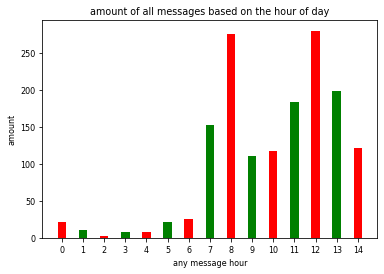

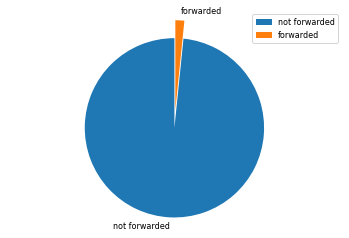

In [16]:
launch_chain(AnyMessageHandler())

In [17]:
class VoiceHandler(MessageHandler):
    def __init__(self):
        self.length_voice = defaultdict(int)
        self.voices_per_hour = defaultdict(int)

    def handle(self, message):
        if message["type"] == "voice":
            self.length_voice[message["duration"]] += 1
            hour = int(re.search("\s[0-9]+", message["date"]).group(0).lstrip())
            self.voices_per_hour[f"{hour}"] += 1
        else:
            super().handle(message)

    def response(self) -> None:
        for res in [
            (
                self.length_voice,
                "voice duration",
                "amount",
                "amount of voices based on their duration",
                True,
            ),
            (
                {k: self.voices_per_hour[k] for k in sorted(self.voices_per_hour)},
                "voice hour",
                "amount",
                "amount of voices based on the hour of day",
                True,
            ),
        ]:
            draw_single_res(*res)

        super().response()

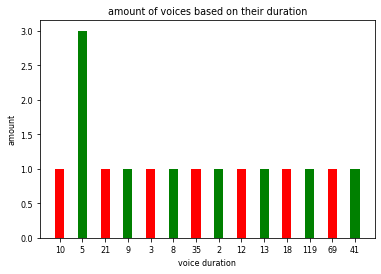

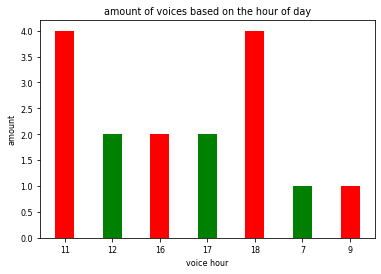

In [18]:
launch_chain(VoiceHandler())

In [19]:
import datetime
from string import punctuation
import langdetect
from dateutil import parser

PUKIN_STARTED_WAR = datetime.date(year=2022, month=2, day=24)
ALCO_LIST = ["пив", "водк", "вино", "ликер", "виски", "сидр"]
alco_list_conversion = {
    "пив": "пиво",
    "водк": "водка",
}
NEOLOGISMS = ["кек", "лол", "рофл", "кринж", ]


class TextHandler(MessageHandler):
    def __init__(self):
        self.length_message: defaultdict = defaultdict(int)
        self.words_amount: defaultdict = defaultdict(int)
        self.messages_per_hour = defaultdict(int)
        self.symbol_amount = defaultdict(int)
        self.punctuation = defaultdict(int)
        self.upper_lower = defaultdict(int)  # message
        self.upper_lower_sym = defaultdict(int)  # syms
        self.languages = defaultdict(int)
        self.messages_by_lang_war = defaultdict(int)
        self.messages_by_lang_before_war = defaultdict(int)
        self.major_alcocholics = defaultdict(int)  # amount of alco mentioned by user
        self.major_alco_mentioned = defaultdict(int)  # amount of mentions of certain type of alco
        self.neologisms_mentioned = defaultdict(int)

    def handle(self, message: dict) -> None:
        if message["type"] == "text":
            text = message["message"]

            if len(alco_mentioned := [alco for alco in ALCO_LIST if alco in text]):
                self.major_alcocholics[message["id"]] += 1

                for alco in alco_mentioned:
                    self.major_alco_mentioned[alco_list_conversion.get(alco, alco)] += text.count(alco)

            if neos_used := [neo for neo in NEOLOGISMS if neo in text]:
                for neo in neos_used:
                    self.neologisms_mentioned[neo] += text.count(neo)

            message_date = parser.parse(message["date"])
            self.length_message[len(text)] += 1

            self.words_amount[len(text.split())] += 1

            hour = message_date.hour
            self.messages_per_hour[f"{hour}"] += 1

            if text.lower() == text:

                for sym in text:
                    self.symbol_amount[sym] += 1

                self.upper_lower_sym["lower case symbol"] += len(text)
                self.upper_lower["lower case message"] += 1

            elif text.upper() == text:

                for sym in text:
                    self.symbol_amount[sym] += 1

                self.upper_lower_sym["upper case symbol"] += len(text)
                self.upper_lower["upper case message"] += 1
            else:

                for sym in text:
                    self.symbol_amount[sym] += 1

                    upper_lower_sym_key = "upper case symbol" if sym.isupper() else "lower case symbol"
                    self.upper_lower_sym[upper_lower_sym_key] += 1

            punctuation_case_key = "with punctuation" \
                if any(s in punctuation for s in text) else "without punctuation"
            self.punctuation[punctuation_case_key] += 1

            try:
                lang = langdetect.detect(text)
                if lang in ["uk", "ru"]:
                    self.languages[lang] += 1

                    if message_date.date() < PUKIN_STARTED_WAR:
                        self.messages_by_lang_before_war[lang] += 1
                    else:
                        self.messages_by_lang_war[lang] += 1
            except Exception:
                pass
        else:
            super().handle(message)

    def response(self) -> None:
        for res in [
            (self.length_message, "message_length", "amount", "amount of messages based on their length"),
            (self.words_amount, "words in message", "amount", "amount of messages based on their words amount"),
            (
                    {k: self.messages_per_hour[k] for k in sorted(self.messages_per_hour)},
                    "message hour",
                    "amount",
                    "amount of messages based on the hour of day",
                    True
            ),
        ]:
            draw_single_res(*res)

        for res in [
            (self.neologisms_mentioned, True, "neologism mentions by users"),
            (self.symbol_amount, True, "symbols by their amount"),
            (self.major_alcocholics, True, "alco mentions by users"),
            (self.major_alco_mentioned, True, "alco mentions by type"),
            (self.punctuation, True, "punctuation used"),
            (self.upper_lower_sym, True, "upper lower symbols used"),
            (self.upper_lower, True, "upper lower messages"),
            (self.languages, False, "languages used for all time"),
            (self.messages_by_lang_before_war, True, "Lang of messages before war"),
            (self.messages_by_lang_war, True, "Lang of messages during war"),
        ]:
            draw_circle_graph(*res)

        super().response()

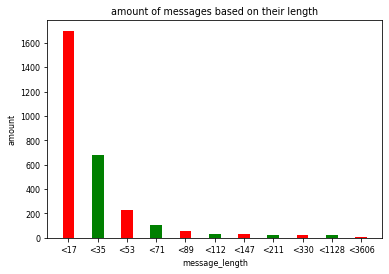

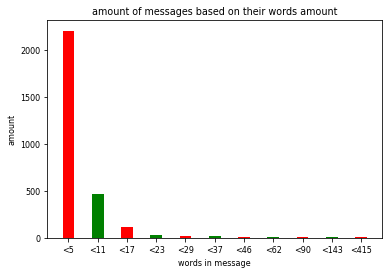

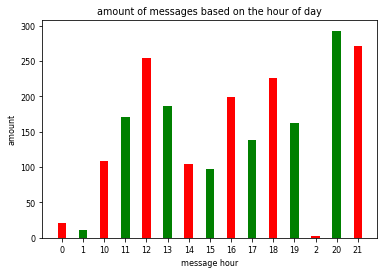

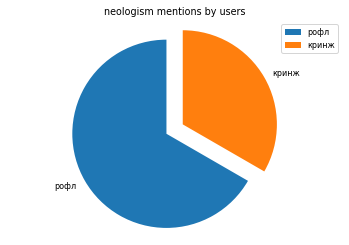

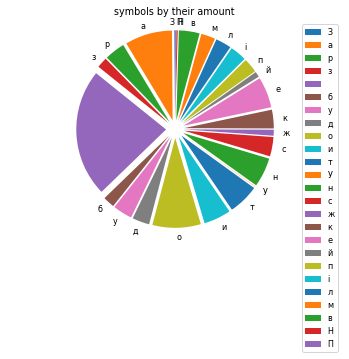

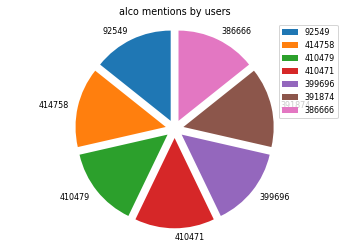

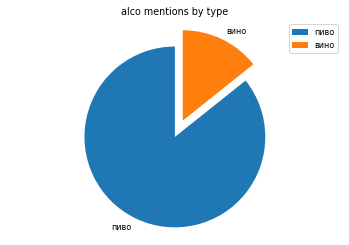

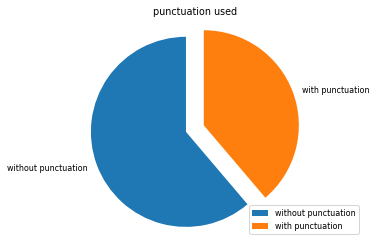

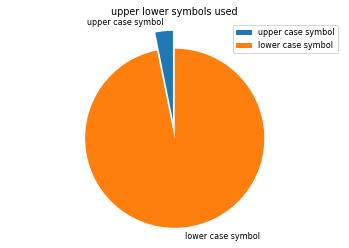

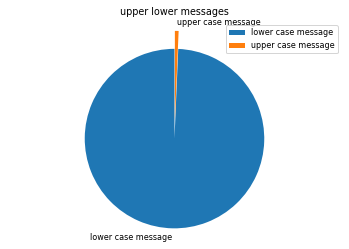

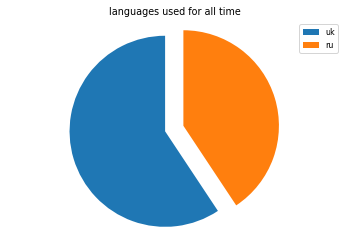

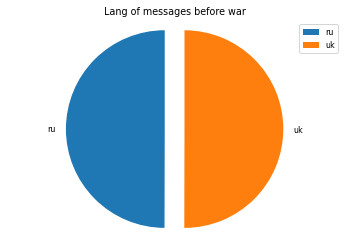

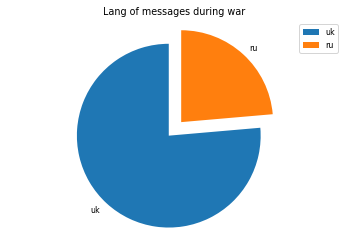

In [20]:
launch_chain(TextHandler())

In [21]:
class PhotoHandler(MessageHandler):
    def __init__(self):
        self.photos_per_hour = defaultdict(int)

    def handle(self, message: dict):
        if message["type"] == "photo":
            hour = int(re.search("\s[0-9]+", message["date"]).group(0).lstrip())
            self.photos_per_hour[hour] += 1
        else:
            super().handle(message)

    def response(self):
        for res in [
            (
                {k: self.photos_per_hour[k] for k in  sorted(self.photos_per_hour)},
                "photo hour",
                "amount",
                "amount of photos based on the hour of day",
                True,
            ),
        ]:
            draw_single_res(*res)

        super().response()

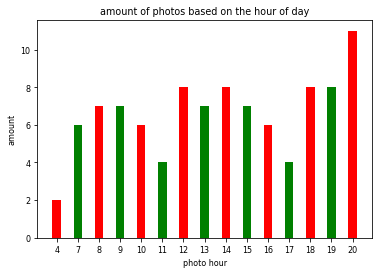

In [22]:
launch_chain(PhotoHandler())

In [23]:
class VideoHandler(MessageHandler):
    def __init__(self):
        self.length_video = defaultdict(int)
        self.videos_per_hour = defaultdict(int)

    def handle(self, message: dict):
        if message["type"] == "video":

            hour = int(re.search("\s[0-9]+", message["date"]).group(0).lstrip())
            self.videos_per_hour[hour] += 1
            self.length_video[message["duration"]] += 1
        else:
            super().handle(message)

    def response(self):
        for res in [
            (
                self.length_video,
                "video duration",
                "amount",
                "amount of videos based on their duration",
                True,
            ),
            (
                {k: self.videos_per_hour[k] for k in sorted(self.videos_per_hour)},
                "video hour",
                "amount",
                "amount of videos based on the hour of day",
                True,
            ),
        ]:
            draw_single_res(*res)

        super().response()

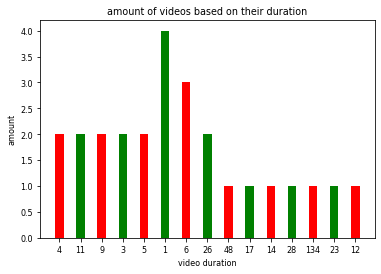

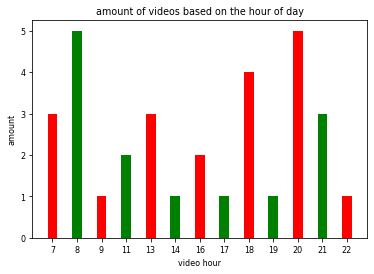

In [24]:
launch_chain(VideoHandler())